In [1]:
#import wradlib as wrl
import os
import numpy as np
import matplotlib.image as image
import matplotlib as mpl
import matplotlib.pyplot as pl
import warnings
warnings.filterwarnings('ignore')
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()
from scipy import interpolate
import datetime as dt
import glob
import json
from datetime import datetime

import pandas as pd

import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, Hodograph, SkewT
from metpy.units import units
from scipy.signal import medfilt
# import sharppy
# import sharppy.sharptab.profile as profile
# import sharppy.sharptab.interp as interp
# import sharppy.sharptab.winds as winds
# import sharppy.sharptab.utils as utils
# import sharppy.sharptab.params as params
# import sharppy.sharptab.thermo as thermo

In [4]:
with open('/home/lmathias/Documents/metpy/bufr10618/sounding.json') as json_file:
    rs_data = json.load(json_file)
    
#with open('/home/lmathias/Desktop/SOUNDING/sounding2.json') as json_file:
    #rs_data2 = json.load(json_file)

meta=rs_data[1]
year=meta[12]
print(year)
month=meta[13]
print(month)
day=meta[14]
print(day)
hour=meta[15]
print(hour)

data=rs_data[3]
data=np.array(data[2])
wmoid=data[0,3]
print(wmoid)
starthour=data[0,38]
startminute=data[0,39]
lat=data[0,41]
lon=data[0,42]
#height=data[0,43]

metdata=data[0,68:21008]
#metdata=metdata[:-13]

press=metdata[::10]/100*units.hPa
press=press.astype(float)
size = press.size
print(size)
height=metdata[1::10]
height=height.astype(float)
height=height*units.meter
height = height[0:size]
temp=(metdata[4::10]-273.15)*units.degC
temp=temp.astype(float)
print(temp.size)
dew=(metdata[5::10]-273.15)*units.degC
dew=dew.astype(float)
dew = dew[0:size]
wdir=metdata[6::10]* units.degrees
wdir = wdir.astype(int)
wdir = wdir[0:size]
print(wdir.size)
size = wdir.size
print(size)
wspd=metdata[7::10]* units('meters/second')
wspd= wspd.astype(float)
wspd = wspd[0:size]
print(wspd.size)
temp = temp[0:size]
print(temp.size)
press = press[0:size]
dew = dew[0:size]
height = height[0:size]
u, v = mpcalc.wind_components(wspd, wdir)


#q = mpcalc.specific_humidity_from_dewpoint(dew,press)
#m = mpcalc.mixing_ratio_from_specific_humidity(q)
#tempv = mpcalc.virtual_temperature(temp,m)
#tw = mpcalc.wet_bulb_temperature(press,temp,dew)

pressf=medfilt(press)*units.hPa
print(pressf.size)
heightf=medfilt(height)*units.meter
print(heightf.size)

2022
11
13
18
10618           
1713
1713
1713
1713
1713
1713
1713
1713


11.699678165122407 degree_Celsius
0 joule / kilogram
[376.1 array([3115.0]) array([5747.9]) array([9394.0]) array([12022.7])] meter


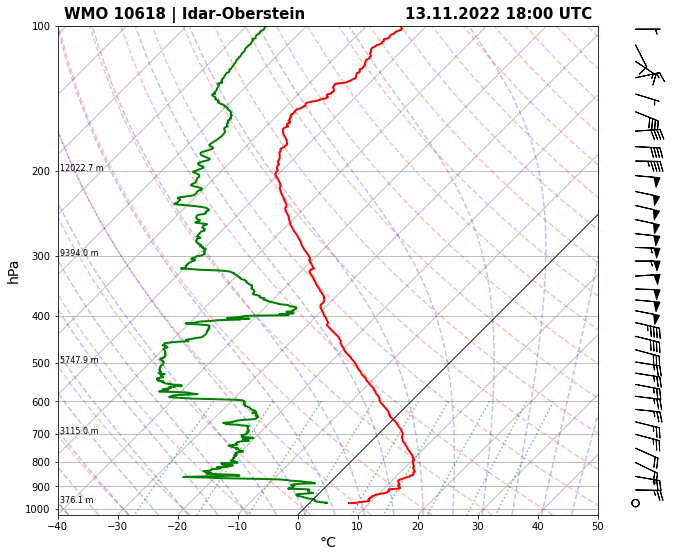

In [7]:
#im = image.imread('meteolux.jpg')
#im2 = image.imread('dwd.png')

# Calculate the LCL

lcl_pressure, lcl_temperature = mpcalc.lcl(press[0], temp[0], dew[0])

# Calculate the parcel profile.
parcel_prof = mpcalc.parcel_profile(pressf, temp[0], dew[0]).to('degC')
parcel_t_start = parcel_prof.T[0]
parcel_p_start = pressf[0]

#mixed_temp = mpcalc.mixed_layer(pressf, temp, heights=None, bottom=None, depth=50*units.hPa)
#mixed_dew = mpcalc.mixed_layer(pressf, dew, heights=None, bottom=None, depth=50*units.hPa)
#mixed_press = mpcalc.mixed_layer(pressf, pressf, heights=None, bottom=None, depth=50*units.hPa)

mixed_press, mixed_temp, mixed_dew = mpcalc.mixed_parcel(pressf, temp, dew, depth=50*units.hPa)
print(mixed_temp)

mixed_parcel_prof = mpcalc.parcel_profile(pressf, mixed_temp, mixed_dew)

mixed_lcl_pressure, mixed_lcl_temperature = mpcalc.lcl(pressf[0], mixed_temp, mixed_dew)

#Calculate CAPE/CIN
sb_cape, sb_cin=mpcalc.surface_based_cape_cin(pressf,temp,dew)
print(sb_cape)
if sb_cape.magnitude<0.1:
    sb_cape=0*units('joule / kilogram')
    sb_cin=-999.9*units('joule / kilogram')
    lfc_pressure,lfc_temperature = np.nan *units.hPa , np.nan * units.degC
    el_pressure, el_temperature = np.nan *units.hPa , np.nan * units.degC
mu_cape, mu_cin=mpcalc.most_unstable_cape_cin(pressf,temp,dew)
if mu_cape.magnitude<0.1:
    mu_cape=0*units('joule / kilogram')
    mu_cin=-999.9*units('joule / kilogram')
ml_cape, ml_cin=mpcalc.mixed_layer_cape_cin(pressf,temp,dew,depth=50*units.hPa)
if ml_cape.magnitude<0.1:
    ml_cape=0*units('joule / kilogram')
    ml_cin=-999.9*units('joule / kilogram')
                                                                                                  
# Calculate bulk shear
u_shear_1km,v_shear_1km = mpcalc.bulk_shear(pressf,u,v,height=height,depth=1000*units.meter,bottom=height[0])
bulk_shear_1km = np.sqrt(u_shear_1km**2 + v_shear_1km**2)
bulk_shear_1km_dir = mpcalc.wind_direction(u_shear_1km,v_shear_1km)

u_shear_3km,v_shear_3km = mpcalc.bulk_shear(pressf,u,v,height=height,depth=3000*units.meter,bottom=height[0])
bulk_shear_3km = np.sqrt(u_shear_3km**2 + v_shear_3km**2)
bulk_shear_3km_dir = mpcalc.wind_direction(u_shear_3km,v_shear_3km)
#print(bulk_shear_3km)

u_shear_6km,v_shear_6km = mpcalc.bulk_shear(pressf,u,v,height=height,depth=6000*units.meter,bottom=height[0])
bulk_shear_6km = np.sqrt(u_shear_6km**2 + v_shear_6km**2)
bulk_shear_6km_dir = mpcalc.wind_direction(u_shear_6km,v_shear_6km)
#print(bulk_shear_6km)

# # Calculate storm motion and helicity
# rmover,lmover,bunk_mean = mpcalc.bunkers_storm_motion(press,u,v,height)
# srh_0to3_pos, srh_0to3_neg, srh_0to3_tot = mpcalc.storm_relative_helicity(u,v,height,3000*units.meter,storm_u=rmover.item(0),storm_v=rmover.item(1))
# srh_0to1_pos, srh_0to1_neg, srh_0to1_tot = mpcalc.storm_relative_helicity(u,v,height,1000*units.meter,storm_u=rmover.item(0),storm_v=rmover.item(1))
# srh_0to500_pos, srh_0to500_neg, srh_0to500_tot = mpcalc.storm_relative_helicity(u,v,height,500*units.meter,storm_u=rmover.item(0),storm_v=rmover.item(1))

# Calculate precipitable water
#pwat = mpcalc.precipitable_water(dew,pressf)

#prof = profile.create_profile(profile='default', pres=pressf, hght=heightf, tmpc=temp, \
                                    #dwpc=dew, wspd=wspd, wdir=wdir, missing=-9999, strictQC=False)

#dcape = params.dcape(prof)
#ship = params.ship(prof)
#pe = params.precip_eff(prof)

fig = pl.figure(figsize=(11, 9))
skew = SkewT(fig, rotation=45)
#skew.plot(press, tempv, color='purple', linewidth=1.5)
#skew.plot(press, tw, color='blue', linewidth=2.5)
skew.plot(press, temp, 'r', linewidth=2.)
skew.plot(press, dew, 'g',linewidth=2)
skew.plot_barbs(press[::50], u[::50]*1.94384, v[::50]*1.94384,y_clip_radius=0.020, xloc=1.07)
skew.ax.set_ylim(1030, 100)
skew.ax.set_xlim(-40, 50)

#skew.plot(mixed_lcl_pressure, mixed_lcl_temperature, 'k.', markerfacecolor='black')

#skew.plot(pressf, mixed_parcel_prof, 'k', linewidth=1.2, linestyle='-.')

# lclt = lcl_temperature.magnitude
# print(lclt)
# list1=np.where(parcel_prof>lclt*units.degC)
# index = np.max(list1)
# print(list1)
# skew.shade_cape(pressf[index:], temp[index:], mixed_parcel_prof[index:])
#skew.shade_cape(press[index:], temp[index:], parcel_prof[index:])

skew.ax.axvline(0, color='k', linestyle='-', linewidth=0.75)
#skew.ax.axvline(-10, color='b', linestyle='--', linewidth=0.75)
#skew.ax.axvline(-30, color='b', linestyle='--', linewidth=0.75)
skew.plot_dry_adiabats(t0=np.arange(233, 533, 10) * units.K,
                       alpha=0.25, color='orangered')
skew.plot_moist_adiabats(t0=np.arange(233, 400, 5) * units.K,
                         alpha=0.25, color='tab:green')
skew.plot_mixing_lines(linestyle='dotted', alpha=0.5, color='tab:blue')

skew.ax.set_ylabel('hPa', fontsize=14)
skew.ax.set_xlabel('°C', fontsize=14)
#skew.ax.legend((dew, temp), ('label1', 'label2'), transform=skew.ax.transAxes)
#props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#skew.ax.text(0.05, 0.95, 'LCL: 757mb', transform=skew.ax.transAxes,
             #fontsize=14, verticalalignment='top', bbox=props)

# ax_hod = fig.add_axes([0.95, 0.55, 0.3, 0.3])
# h = Hodograph(ax_hod, component_range=30.)
# h.add_grid(increment=10)
# h.ax.set_ylabel('m/s')
# h.ax.set_xlabel('m/s')
# pl.sca(ax_hod)
# wind_speed = np.sqrt(u**2 + v**2)
# h.plot(u[:1000:40], v[:1000:40], linewidth=2,color='purple')
# h.wind_vectors(rmover.item(0), rmover.item(1), color='red') 
# h.wind_vectors(bunk_mean.item(0), bunk_mean.item(1))
# h.wind_vectors(lmover.item(0), lmover.item(1), color='green')

i = np.where(press==700.0*units.hPa)
k = np.where(press==500.0*units.hPa)
j = np.where(press==300.0*units.hPa)
l = np.where(press==200.0*units.hPa)

# if temp[0].magnitude<=0:
#     zdl = height[0].magnitude
# else:
#     m = np.isclose(temp,0.0,atol=0.1)
#     n = np.where(m==True)
#     print(n)
#     zdl = height[n].magnitude
    
# o = np.isclose(press,mixed_lcl_pressure,atol=1)
# n = np.where(o==True)
# lcl_height=height[n].magnitude

heights = np.array([height[0].magnitude, height[i].magnitude, height[k].magnitude,height[j].magnitude,height[l].magnitude])*units.meter
pressure = np.array([press[0].magnitude,700,500,300,200])*units.hPa
print(heights)
for height_tick, p_tick in zip(heights, pressure):
    trans, _, _ = skew.ax.get_yaxis_text1_transform(0)
    try:
        skew.ax.text(0.005, p_tick, '{:~0}'.format(np.round(height_tick.item(),1)), transform=trans,size=8)
    except: 
        print('Error')

# ax1 = fig.add_axes([0.95,0.16,0.1,0.3])
# ax2 = fig.add_axes([1.15,0.16,0.1,0.3])
# ax1.axis('off')
# ax2.axis('off')
# ax1.text(0.01,1.06,'Lift type:',size=8)
# ax1.text(0.01,1,'Lifted condensation level pressure:',size=8)
# ax1.text(0.01,0.94,'Lifted condensation level height:',size=8)
# ax1.text(0.01,0.88,'Surface-based CAPE:',size=8)
# ax1.text(0.01,0.82,'Surface-based CIN:',size=8)
# ax1.text(0.01,0.76,'Most-unstable CAPE:',size=8)
# ax1.text(0.01,0.7,'Most-unstable CIN:',size=8)
# ax1.text(0.01,0.64,'50-hPa mixed-layer CAPE:',size=8)
# ax1.text(0.01,0.58,'50-hPa mixed-layer CIN:',size=8)
# ax1.text(0.01,0.52,'Downdraft CAPE:',size=8)
# ax1.text(0.01,0.40,'0-1 km bulk shear:',size=8)
# ax1.text(0.01,0.34,'0-3 km bulk shear:',size=8)
# ax1.text(0.01,0.28,'0-6 km bulk shear:',size=8)
# ax1.text(0.01,0.22,'0-1 km storm-relative helicity (RM):',size=8)
# ax1.text(0.01,0.16,'0-3 km storm-relative helicity (RM):',size=8)
# ax1.text(0.01,0.04,'Precipitable water:',size=8)
# ax1.text(0.01,-0.02,'Precipitation efficiency:',size=8)
# ax1.text(0.01,-0.14,'Significant hail parameter:',size=8)
# ax1.text(0.01,-0.20,'Freezing level:',size=8)

# #ax1.text(0.01,-0.08,'SCP',size=8)
# #ax1.text(0.01,-0.14,'STP',size=8)
# #ax1.text(0.01,-0.14,'Lapse Rate',size=8)

# #ax2.text(0.01,1.0,'{0} hPa'.format(np.round(parcel_p_start.magnitude,1)),size=8)
# ax2.text(0.01,1.06,'50-hPa mixed layer',size=8)
# ax2.text(0.01,1,'{0} hPa'.format(np.round(mixed_lcl_pressure.magnitude,1)),size=8)
# ax2.text(0.01,0.94,'{0} m'.format(np.round(lcl_height.item(0),1)),size=8)
# ax2.text(0.01,0.88,'{0} J/kg'.format(np.round(sb_cape.magnitude,1)),size=8)
# ax2.text(0.01,0.82,'{0} J/kg'.format(np.round(sb_cin.magnitude,1)),size=8)
# ax2.text(0.01,0.76,'{0} J/kg'.format(np.round(mu_cape.magnitude,1)),size=8)
# ax2.text(0.01,0.7,'{0} J/kg'.format(np.round(mu_cin.magnitude,1)),size=8)
# ax2.text(0.01,0.64,'{0} J/kg'.format(np.round(ml_cape.magnitude,1)),size=8)
# ax2.text(0.01,0.58,'{0} J/kg'.format(np.round(ml_cin.magnitude,1)),size=8)
# ax2.text(0.01,0.52,'{0} J/kg'.format(np.round(dcape[0],1)),size=8)
# ax2.text(0.01,0.40,'{0} m/s'.format(np.round(bulk_shear_1km.magnitude,1)),size=8)
# ax2.text(0.01,0.34,'{0} m/s'.format(np.round(bulk_shear_3km.magnitude,1)),size=8)
# ax2.text(0.01,0.28,'{0} m/s'.format(np.round(bulk_shear_6km.magnitude,1)),size=8)
# ax2.text(0.01,0.22,'%s m$^{2}$/s$^{2}$'%np.round(srh_0to1_pos.magnitude,1),size=8)
# ax2.text(0.01,0.16,'%s m$^{2}$/s$^{2}$'%np.round(srh_0to3_pos.magnitude,1),size=8)
# ax2.text(0.01,0.04,'{0} mm'.format(np.round(pwat.magnitude,1)),size=8)
# ax2.text(0.01,-0.02,'{0}'.format(np.round(pe,1)),size=8)
# ax2.text(0.01,-0.14,'{0}'.format(np.round(ship,1)),size=8)
# ax2.text(0.01,-0.20,'{0} m'.format(np.round(zdl.item(0),1)),size=8)
# #ax2.text(0.01,0.04,'{0} kts at {1} deg'.format(float(stats[19]),float(stats[20])),size=8)
# #ax2.text(0.01,-0.02,'{0} in'.format(np.round(float(stats[21])/25.4,2)),size=8)

t1 = fig.text(0.18, 0.890, 'WMO 10618 | Idar-Oberstein', fontsize=15, fontweight='bold')
t2 = fig.text(0.61, 0.890, datetime.strftime(datetime(year,month,day,hour,0,0),"%d.%m.%Y %H:%M UTC"),fontsize=15, fontweight='bold')
#t3 = fig.text(0.05, 0.090, 'Copyright: MeteoLux, DWD', fontsize=6)
# t3 = fig.text(0.98, 0.820, 'LM', fontsize=9, fontweight='bold', color='green')
# t4 = fig.text(0.98, 0.800, 'RM', fontsize=9, fontweight='bold', color='red')

#ax3 = fig.add_axes([0.73,0.73,0.12,0.25])
#ax3.axis('off')
#ax3.imshow(im, aspect='equal', origin='upper', zorder=6)
#ax4 = fig.add_axes([0.73,0.66,0.12,0.25])
#ax4.axis('off')
#ax4.imshow(im2, aspect='equal', origin='upper', zorder=6)

pl.savefig('sounding_10618_'+(datetime.strftime(datetime(year,month,day,hour,0,0),"%Y%m%d%H%M"))+'_env.jpeg', format="jpeg", bbox_inches='tight',dpi=120)